<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Tabular_Playground_Series_May_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_test.csv')
train.shape, test.shape

((100000, 52), (50000, 51))

In [ ]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

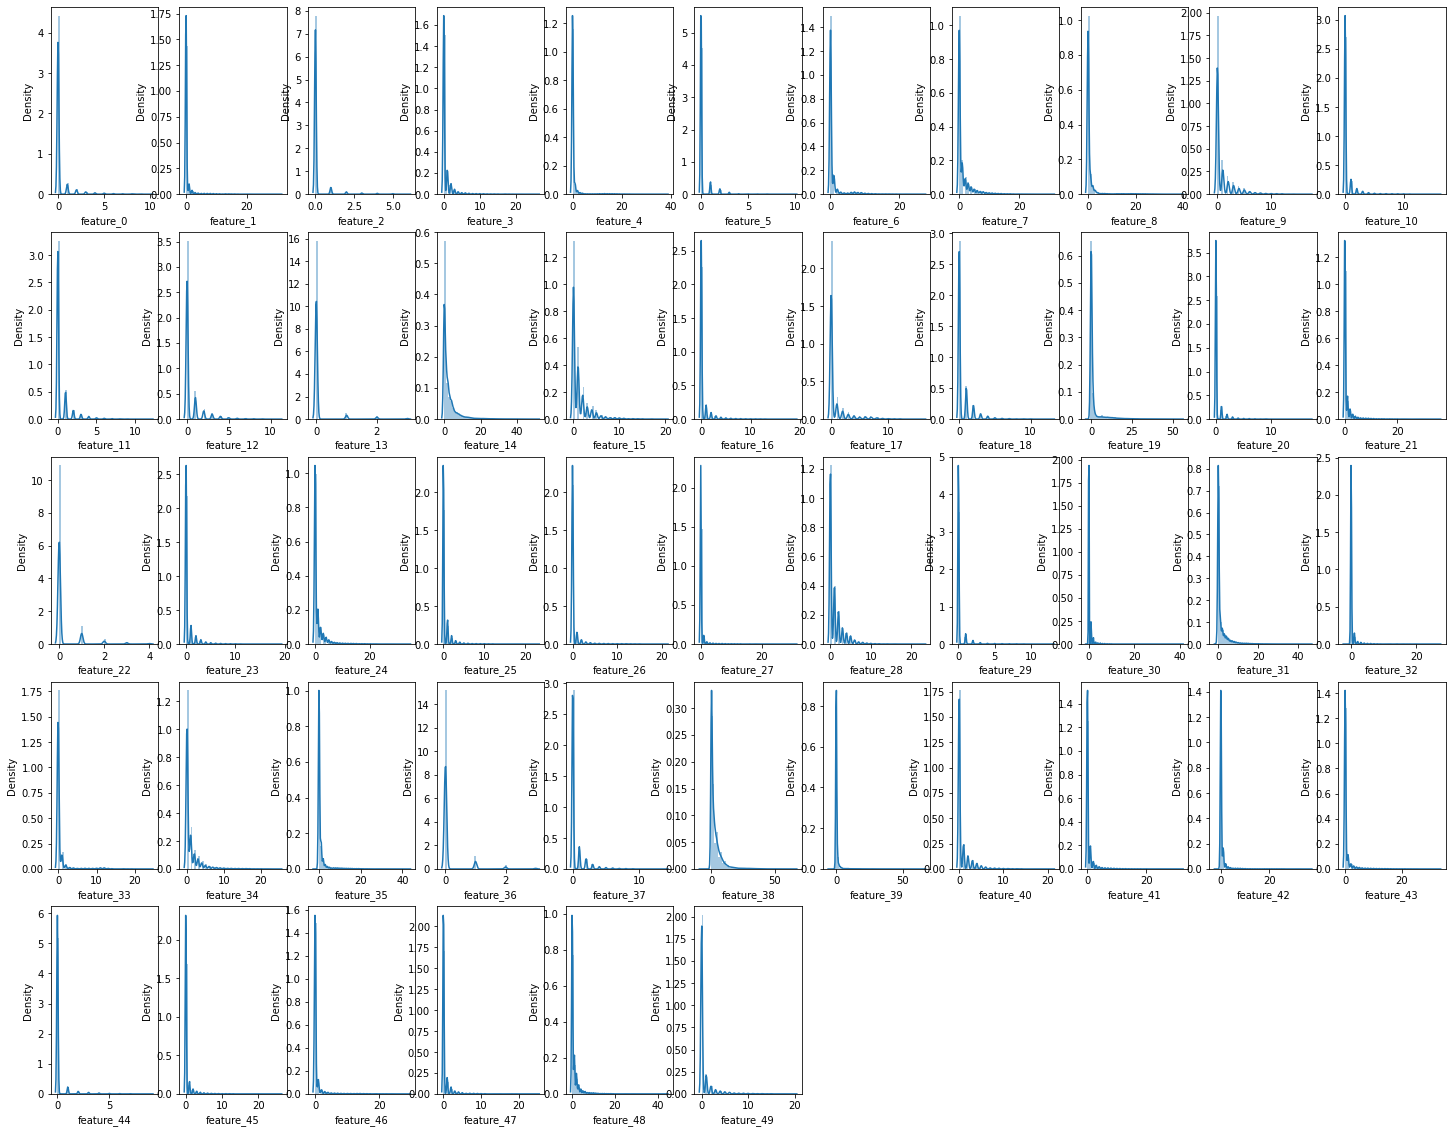

In [ ]:
fig = plt.figure(figsize=(25,20))
for i, j in enumerate(train.drop(columns=['id', 'target']).columns):
  plt.subplot(5,11, i+1)
  sns.distplot(train[j])
plt.subplots_adjust()

In [ ]:
def scaling(df):
  for i in df.columns:
    if i in ['id', 'target']:
      continue
    if df[i].skew() > 0.5:
      df[i] = np.log1p(1+df[i])
  return df

In [ ]:
def normaliation(df):
  for i in df.columns:
    if i in ['id', 'target']:
      continue
    df[i] = df[i].astype('float')
    df[i] = stats.yeojohnson(df[i], stats.yeojohnson_normmax(df[i]+1))

  return df

In [ ]:
def aggregation(df):
  temp_col = []
  temp_agg = df.groupby('id').agg(['median'])
  for i in temp_agg.columns.levels[0]:
    for j in temp_agg.columns.levels[1]:
      temp_col.append(f'{i}-{j}')

  temp_agg.columns = temp_col

  corr_matrix = temp_agg.corr()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [c for c in upper.columns if any(abs(upper[c]) > 0.9)]

  temp_agg.drop(columns=to_drop)

  return temp_agg
# 성능 안좋음

In [ ]:
train_agg = aggregation(train)
test_agg = aggregation(test)

In [ ]:
train = train.merge(train_agg, how='left', on='id')
test = test.merge(test_agg, how='left', on='id')

# Clustering

In [ ]:
df_cl = pd.concat([train.drop(columns=['id', 'target']), test.drop(columns='id')])
df_cl_col = df_cl.columns

train_cl = train.drop(columns=['id', 'target'])
train_cl_col = train_cl.columns

test_cl = test.drop(columns=['id'])
test_cl_col = test_cl.columns

In [ ]:
from sklearn.cluster import KMeans

ssc = {}
for i in range(1, 20):
  km = KMeans(n_clusters=i, algorithm='auto', n_jobs=-1).fit(df_cl)
  ssc[i] = km.inertia_

([<matplotlib.axis.XTick at 0x7f2c31d85cd0>,
 <a list of 19 Text major ticklabel objects>)

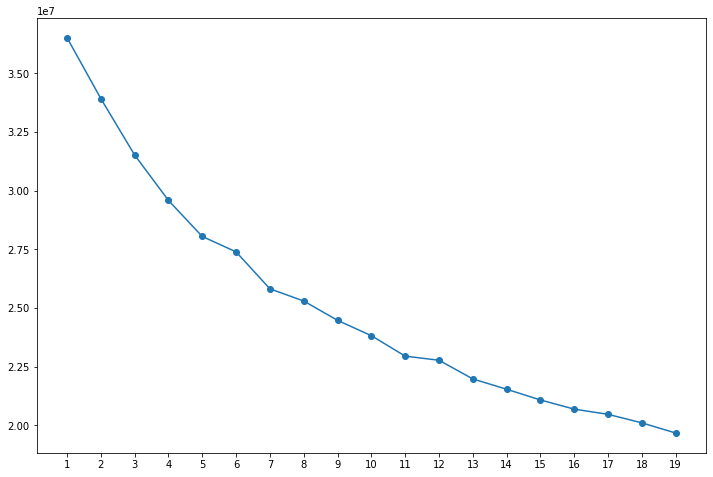

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(pd.Series(ssc).index, pd.Series(ssc), marker='o')
plt.xticks(pd.Series(ssc).index)

In [ ]:
km = KMeans(n_clusters=7, algorithm='auto', n_jobs=-1).fit(df_cl)

train['cluster'] = km.predict(train_cl)
test['cluster'] = km.predict(test_cl)

In [ ]:
train = pd.get_dummies(data=train, columns=['cluster'])
test = pd.get_dummies(data=test, columns=['cluster'])

# 로그변환과 normalization을 하면 데이터가 이상해진다...

In [ ]:
pip install catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [ ]:
pip install optuna

     |████████████████████████████████| 307kB 15.3MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 174kB 67.7MB/s 
     |████████████████████████████████| 112kB 59.2MB/s 
     |████████████████████████████████| 143kB 83.0MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=9392b1dce0185cb13f9ce4ba472012e2940249521a7dd6b7296aa700eb4ef444
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from sklearn.preprocessing import LabelEncoder, robust_scale, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import log_loss
import optuna
import catboost
import xgboost
import lightgbm as lgbm

In [ ]:
x_train = train.drop(columns=['id', 'target'])
y_train = train['target']
x_test = test.drop(columns=['id'])
x_train.shape, y_train.shape, x_test.shape

((100000, 50), (100000,), (50000, 50))

In [ ]:
y_train = pd.Series(LabelEncoder().fit_transform(y_train))

In [ ]:
train_col = x_train.columns
test_col = x_test.columns

sc = StandardScaler().fit(x_train)

x_train = pd.DataFrame(sc.transform(x_train), columns=train_col)
x_test = pd.DataFrame(sc.transform(x_test), columns=test_col)

# PCA

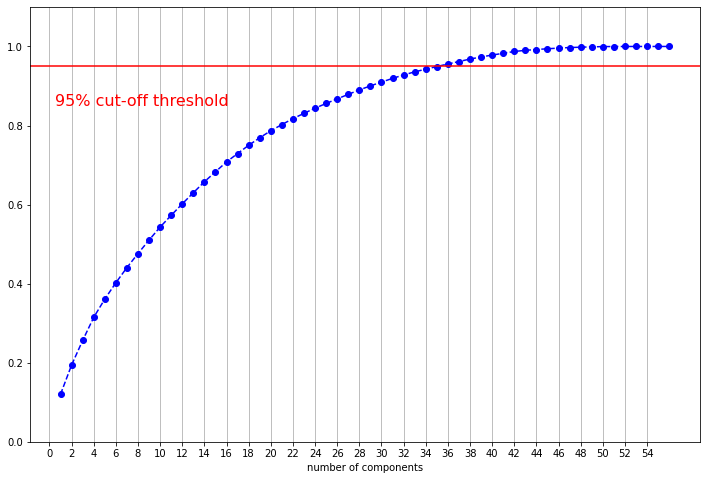

In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(svd_solver='auto', whiten=True)
pca.fit(x_train)

fig, ax = plt.subplots(figsize=(12,8))
xi = np.arange(1, len(x_train.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('number of components')
plt.xticks(np.arange(0, len(x_train.columns), step=2))

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()
# 성능이 별로 안좋다...

In [ ]:
pca = PCA(n_components=36,svd_solver='auto', whiten=True)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

# 여기까지 PCA 안좋다...

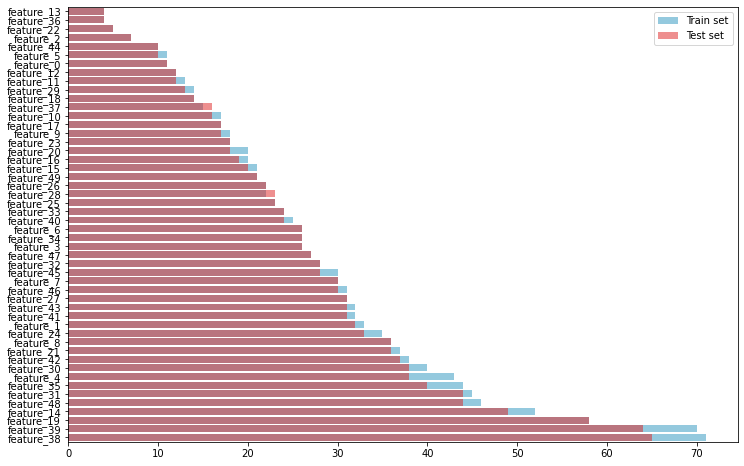

In [ ]:
a = x_train.nunique().sort_values()
b = x_test.nunique().sort_values()
plt.figure(figsize=(12, 8))
sns.barplot(y=a.index, x=a, color='skyblue', label='Train set')
sns.barplot(y=b.index, x=b, color='red', label='Test set', alpha=0.5)
plt.legend()

In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 13.3MB/s 


In [ ]:
# feature selection
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostClassifier(loss_function='MultiClass',
                                   eval_metric='MultiClass',
                                   verbose=False,
                                   task_type='GPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_sel, scoring='neg_log_loss', random_state=12)
perm.fit(X_test, Y_test)

PermutationImportance(cv='prefit',
                      estimator=<catboost.core.CatBoostClassifier object at 0x7f2c128f58d0>,
                      n_iter=5, random_state=12, refit=True,
                      scoring='neg_log_loss')

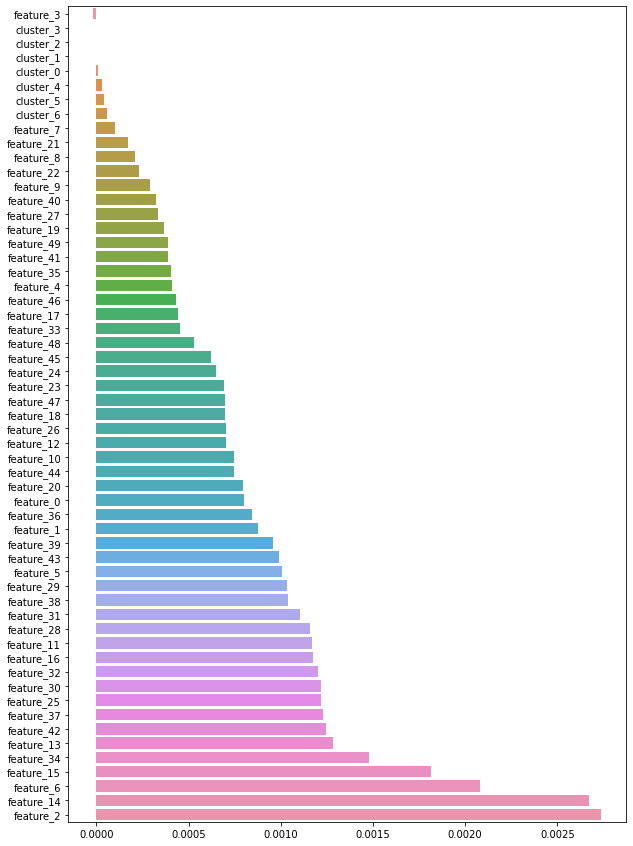

In [ ]:
importance = pd.Series(perm.feature_importances_, index=train.drop(columns=['id', 'target']).columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [ ]:
x_train = x_train.drop(columns=drop_sel)
x_test = x_test.drop(columns=drop_sel)

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'MultiClass',
              'eval_metric':'MultiClass',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide'
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(f'Best trial score{study.best_trial.value}, params{study.best_trial.params}')

[I 2021-07-06 07:44:33,784] A new study created in memory with name: no-name-48fe0b9c-4ca9-4c6c-91ab-8e011211fe56
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-07-06 07:45:16,390] Trial 0 finished with value: 1.089401557117656 and parameters: {'iterations': 23155, 'learning_rate': 0.27552735374326687, 'reg_lambda': 17.543553151393095, 'subsample': 0.6269431851990757, 'random_strength': 49.3236530862401, 'depth': 4, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 1.089401557117656.
[I 2021-07-06 07:46:27,263] Trial 1 finished with value: 1.089954401994652 and parameters: {'iterations': 5485, 'learning_rate': 0.16942230950127585, 'reg_lambda': 21.081883568188438, 'subsample': 0.8056439478054607, 'random_strength': 31.50355829433661, 'depth': 10, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 7}. Best is trial 0 with value: 1.089401557117656.
[I 2021-07-06 07:49:03,511] Trial 2 finished 

Best trial score1.0853767453402385, params{'iterations': 22007, 'learning_rate': 0.21103771257651024, 'reg_lambda': 48.19689112609351, 'subsample': 0.11158469973653287, 'random_strength': 23.315811192792136, 'depth': 1, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 1}


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_cat = np.zeros((x_test.shape[0], y_train.nunique()))
params_cat = {
    'iterations':study.best_params['iterations'],
    'loss_function':'MultiClass',
    'task_type':"GPU",
    'eval_metric':'MultiClass',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth': study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Lossguide'
}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train[train_index], x_train[valid_index]
  Y_train, Y_valid = y_train[train_index], y_train[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat += model_cat.predict_proba(x_test) / skf.n_splits

0:	learn: 1.2855886	test: 1.2855325	best: 1.2855325 (0)	total: 9.95ms	remaining: 53.9s
100:	learn: 1.1046446	test: 1.1075531	best: 1.1075531 (100)	total: 778ms	remaining: 40.9s
200:	learn: 1.1013594	test: 1.1050193	best: 1.1050193 (200)	total: 1.54s	remaining: 39.9s
300:	learn: 1.0995408	test: 1.1042981	best: 1.1042981 (300)	total: 2.28s	remaining: 38.8s
400:	learn: 1.0983390	test: 1.1038980	best: 1.1038057 (375)	total: 3.07s	remaining: 38.4s
500:	learn: 1.0973834	test: 1.1036156	best: 1.1036156 (500)	total: 3.82s	remaining: 37.4s
600:	learn: 1.0966543	test: 1.1033889	best: 1.1033778 (594)	total: 4.57s	remaining: 36.6s
700:	learn: 1.0959752	test: 1.1033117	best: 1.1032845 (668)	total: 5.3s	remaining: 35.6s
800:	learn: 1.0954202	test: 1.1032797	best: 1.1031906 (750)	total: 6.03s	remaining: 34.7s
bestTest = 1.103190625
bestIteration = 750
Shrink model to first 751 iterations.
0:	learn: 1.2855579	test: 1.2855260	best: 1.2855260 (0)	total: 8.55ms	remaining: 46.3s
100:	learn: 1.1050656	test

In [ ]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'n_estimators':trial.suggest_int("n_estimators", 2000, 25000),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 30.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 30.0),
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
              'subsample': trial.suggest_uniform('subsample', 0,1),
              'learning_rate': trial.suggest_uniform('learning_rate', 0, 0.1 ),
              'max_depth': trial.suggest_int('max_depth', 1,12),
              'num_leaves' : trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
              'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
              'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
              'cat_l2': trial.suggest_int('cat_l2',1,20),
              'metric': 'multi_logloss', 
              'random_state' : trial.suggest_categorical('random_state',[13]),
              'objective': 'multiclass',
              'tree_method':'gpu_hist'
               }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(f'Best trial score{study.best_trial.value}, params{study.best_trial.params}')

[I 2021-06-30 11:49:14,192] A new study created in memory with name: no-name-fac46561-c5ca-4d36-a56f-b67c7e1a191e
[I 2021-06-30 11:49:16,454] Trial 0 finished with value: 1.377924437135458 and parameters: {'n_estimators': 8709, 'reg_alpha': 12.24751824344364, 'reg_lambda': 6.670410731043516, 'colsample_bytree': 0.6, 'subsample': 0.6021533759307922, 'learning_rate': 0.02080897845217361, 'max_depth': 2, 'num_leaves': 62, 'min_child_samples': 67, 'min_child_weight': 0.9504555733559261, 'cat_smooth': 98, 'cat_l2': 20, 'random_state': 13}. Best is trial 0 with value: 1.377924437135458.
[I 2021-06-30 11:49:33,330] Trial 1 finished with value: 1.0953160401560367 and parameters: {'n_estimators': 16695, 'reg_alpha': 0.001235055739060126, 'reg_lambda': 0.000613866633729072, 'colsample_bytree': 0.6, 'subsample': 0.5758937059038759, 'learning_rate': 0.06596527107591744, 'max_depth': 9, 'num_leaves': 85, 'min_child_samples': 76, 'min_child_weight': 0.00922594730338476, 'cat_smooth': 35, 'cat_l2': 7

Best trial score1.08627678719908, params{'n_estimators': 20610, 'reg_alpha': 4.477536841233771, 'reg_lambda': 26.193216307436078, 'colsample_bytree': 0.8, 'subsample': 0.6540874182230872, 'learning_rate': 0.05688145635598608, 'max_depth': 3, 'num_leaves': 42, 'min_child_samples': 56, 'min_child_weight': 0.0023167705877421762, 'cat_smooth': 73, 'cat_l2': 16, 'random_state': 13}


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_xgb = np.zeros((x_test.shape[0], y_train.nunique()))
params_xgb = {
    'n_estimators':study.best_params['n_estimators'],
    'reg_alpha': study.best_params['reg_alpha'],
    'reg_lambda': study.best_params['reg_lambda'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'subsample': study.best_params['subsample'],
    'learning_rate': study.best_params['learning_rate'],
    'max_depth': study.best_params['max_depth'],
    'num_leaves' : study.best_params['num_leaves'],
    'min_child_samples': study.best_params['min_child_samples'],
    'min_child_weight' : study.best_params['min_child_weight'],
    'cat_smooth' : study.best_params['cat_smooth'],
    'cat_l2': study.best_params['cat_l2'],
    'random_state' : study.best_params['random_state'],
    'objective': 'multiclass',
    'tree_method':'gpu_hist',
    'grow_policy' : 'lossguide',
}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=70, verbose=100, eval_metric='mlogloss')

  preds_xgb += model_xgb.predict_proba(x_test) / skf.n_splits

[0]	validation_0-mlogloss:1.36391
Will train until validation_0-mlogloss hasn't improved in 70 rounds.
[100]	validation_0-mlogloss:1.10419
[200]	validation_0-mlogloss:1.0989
[300]	validation_0-mlogloss:1.09651
[400]	validation_0-mlogloss:1.09531
[500]	validation_0-mlogloss:1.09478
[600]	validation_0-mlogloss:1.09443
[700]	validation_0-mlogloss:1.09436
Stopping. Best iteration:
[690]	validation_0-mlogloss:1.0943

[0]	validation_0-mlogloss:1.36366
Will train until validation_0-mlogloss hasn't improved in 70 rounds.
[100]	validation_0-mlogloss:1.10317
[200]	validation_0-mlogloss:1.09756
[300]	validation_0-mlogloss:1.09483
[400]	validation_0-mlogloss:1.09339
[500]	validation_0-mlogloss:1.09249
[600]	validation_0-mlogloss:1.09204
[700]	validation_0-mlogloss:1.09177
[800]	validation_0-mlogloss:1.0916
[900]	validation_0-mlogloss:1.09164
Stopping. Best iteration:
[864]	validation_0-mlogloss:1.09156

[0]	validation_0-mlogloss:1.36394
Will train until validation_0-mlogloss hasn't improved in 70 

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_sample_submission.csv')
submit = submit.set_index('id')

In [ ]:
for i in range(y_train.nunique()):
  submit.iloc[:, i] = preds_cat[:, i]

In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/submit5.csv')